# SIRR, не соизволите ли удалить отражение?
**TLDR:** Удаляем отражения с помощью сверточной сети, обученной на синтетическом датасете.

Ниже приведен код для Yandex Datasphere к одноименной статье [SIRR, не соизволите ли удалить отражение?](<span style="color:red">TODO add link</span>).  
Другие варианты кода также доступны на [GitHub'e](<span style="color:red">TODO ссылка на github</span>).  

## 1. Настройка окружения
1.1 Установка библиотек  
1.2 import'ы  
1.3 Определение параметров запуска  
1.4 Определение дополнительных функций-помощников

### 1.1 Установка библиотек

In [1]:
#!L
# https://kornia.readthedocs.io/en/latest/
# https://github.com/albumentations-team/albumentations
%pip install torchsummary kornia albumentations

Defaulting to user installation because normal site-packages is not writeable


### 1.2 import'ы

In [2]:
#!L
import itertools
import json
from datetime import datetime
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

from torchsummary import summary

import torchvision
from torchvision import transforms

import albumentations as A
def transform_wrapper(transform):
    def wrapped(image):
        return transform(image=image)["image"]
    return wrapped

import kornia

print(f'torch_version={torch.__version__}')

torch_version=1.6.0


### 1.3 Определение параметров запуска
- дебаг-флаг
- гиперпараметры датасета (пути, % валидации, seed, размер изображений, аугментации изображений)
- гиперпараметры синтетики (диапазоны коэффициента пропускания и параметра размытия, размеры ядер размытия и отражения)
- устройство для обучения сети (cpu/cuda)
- гиперпараметры обучение (кол-во эпох, частота снепшота модели, размер батча, learning rate)

In [3]:
#!L
DEBUG = False

DATASET_PATHS = {
    'indoor':  './data/indoor',
    'outdoor': './data/outdoor',
}
VAL_PART = 0.2
DATASET_SPLIT_FILES_SEED = 236951592

IMG_SHAPE = np.array([128, 128])
IMG_SHAPE_EXTRA = 1.1

AUGMENTATIONS = transform_wrapper(A.Compose([
    A.Rotate(limit=90, p=0.5),
    A.RandomResizedCrop(*((IMG_SHAPE * IMG_SHAPE_EXTRA).astype(int)))
]))

NUM_DATALOADER_WORKERS = 4

TRANSMISSION_ALPHA = (0.75, 0.8)
GAUSSIAN_KERNEL_SIGMA = (1, 5)
GAUSSIAN_KERNEL_SHAPE = (7, 7)
REFLECTION_KERNEL_SHAPE = (3, 3)

DEVICE = 'cuda'

MAX_EPOCHS = 30
SAVE_MODEL_EPOCHS = 5
BATCH_SIZE = 24
LEARNING_RATE = 1e-4   # find_lr: lr \in [3e-5,7e-4]

### 1.4 Определение дополнительных функций-помощников

Функции для генерации папки, куда пойдут результаты и чекпойнты:

In [4]:
#!L
def generate_result_path():
    path = Path('./result') / str(int(datetime.now().timestamp()))
    path.mkdir(exist_ok=True, parents=True)
    print(path)
    return path

Функции для вывода изображений:

In [5]:
#!L
def imshow(img):
    plt.imshow(img)
    plt.show()

def imshow_chw(img):
    imshow(np.transpose(img, axes=(1, 2, 0)))

def imshow_floattensor(t):
    t = torch.clamp(t, 0, 1)
    img = (t * 255).byte().cpu().numpy()
    imshow_chw(img)

## 2. Датасет

2.1 Скачивание изображений  
2.2 Отбор читаемых файлов  
2.3 Разделение на обучение и валидацию  
2.4 Обертка в PyTorch Dataset'ы  
2.5 Обертка в PyTorch DataLoader'ы  
2.6 Соединение всех Dataloader'ов  
2.7 Определение класса-обертки для генерации синтетики и рассчета loss'а  

### 2.1 Скачивание изображений

1. indoor - [датасет изображений различных помещений](http://web.mit.edu/torralba/www/indoor.html)
2. outdoor - [датасет с фотографиями уличной моды](https://github.com/bearpaw/clothing-co-parsing)
3. data_real - [пара изображений из статьи "Single Image Reflection Removal with Perceptual Losses"](https://github.com/ceciliavision/perceptual-reflection-removal)

In [6]:
#!L
%%writefile download_data.sh

if [ -d "data" ]; then
    echo ">>> Data already downloaded and unpacked <<<"
    exit
fi
    
mkdir -p data
mkdir -p data_real
mkdir -p data_raw

echo ">>> Making data_real <<<"
wget --no-check-certificate "https://docs.google.com/uc?export=download&id=17JaeBOzg3gPguwf96jOw0ZZgHucG4xKL" -O data_real/110.jpg
wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1J9cH-lWaWeQIL9O0LqT1cSSVaAJ0rWMy" -O data_real/110_clean.jpg

echo ">>> Making data/indoor <<<"
if [ ! -f "data_raw/indoorCVPR_09.tar" ]; then
    echo ">>> Downloading indoorCVPR_09.tar <<<"
    wget http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar -O indoorCVPR_09.tar
else
    echo ">>> Using previously downloaded indoorCVPR_09.tar <<<"
    mv data_raw/indoorCVPR_09.tar indoorCVPR_09.tar
fi
tar -C . -xf indoorCVPR_09.tar
mv Images ./data/indoor
mv indoorCVPR_09.tar data_raw/indoorCVPR_09.tar

echo ">>> Making data/outdoor <<<"
if [ ! -f "data_raw/master.zip" ]; then
    echo ">>> Downloading master.zip <<<"
    wget https://github.com/bearpaw/clothing-co-parsing/archive/refs/heads/master.zip
else
    echo ">>> Using previously downloaded master.zip <<<"
    mv data_raw/master.zip master.zip
fi
unzip -qq master.zip clothing-co-parsing-master/photos/*
mv ./clothing-co-parsing-master/photos/ ./data/outdoor
rm -r ./clothing-co-parsing-master
mv master.zip data_raw/master.zip

echo ">>> Finished downloading and unpacking data <<<"

Overwriting download_data.sh


In [7]:
#!L:bash
chmod +x download_data.sh
./download_data.sh

>>> Data already downloaded and unpacked <<<


### 2.2 Отбор читаемых файлов 

In [8]:
#!L
def is_loadable(path):
    try:
        img_bgr = cv2.imread(path)
        return img_bgr is not None
    except:
        return False

def get_loadable_files(path):
    files = []
    for p in tqdm(list(path.glob('**/*'))):
        p = str(p.absolute())
        if is_loadable(p):
            files.append(p)
    return files

def get_files(paths, use_cache=True):
    dataset_files = {}
    for name, path in paths.items():
        path = Path(path)
        cache = path.with_suffix('.files_cache.json')

        if use_cache and cache.exists():
            print(f'Loading files cache for {name}')
            dataset_files[name] = {'all': json.load(cache.open('r'))}
            continue

        print(f'Getting loadable files for {name}')
        loadable_files = get_loadable_files(path)
        if use_cache:
            json.dump(loadable_files, cache.open('w'))
        dataset_files[name] = {'all': loadable_files}

    return dataset_files


dataset_files = get_files(DATASET_PATHS)


if DEBUG:
    for name, files in dataset_files.items():
        print(f'len({name})={len(files["all"])}')

Loading files cache for indoor
Loading files cache for outdoor


### 2.3 Разделение на обучение и валидацию  

In [9]:
#!L
def split_files(dataset_files, val_part, seed):
    rng = np.random.default_rng(seed=seed)
    for name, files in dataset_files.items():
        all = np.array(files['all'])

        ids = np.arange(len(all))
        rng.shuffle(ids)

        val_len = int(val_part * len(all))
        train_ids = ids[val_len:]
        val_ids = ids[:val_len]

        files['all'] = all
        files['val'] = all[val_ids]
        files['train'] = all[train_ids]


split_files(dataset_files, val_part=VAL_PART, seed=DATASET_SPLIT_FILES_SEED)


if DEBUG:
    for name, parts in dataset_files.items():
        print(name)
        for part, files in parts.items():
            print(f'  len({part})={len(files)}')
            print(f'    example="{files[len(files) // 2]}"')

### 2.4 Обертка в PyTorch Dataset'ы

In [10]:
#!L
def cv2loader(path):
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

def transformloader(path, transform):
    img = cv2loader(path)
    if transform:
        img = transform(img)
    return np.transpose(img, axes=(-1, 0, 1))

class TransformedImages(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, item):
        path = self.files[item]
        return transformloader(path, self.transform)

def get_datasets(files, parts_transforms):
    datasets = {}
    for name, files in files.items():
        datasets_for_name = {}
        for part, transform in parts_transforms.items():
            datasets_for_name[part] = \
                TransformedImages(files=files[part], transform=transform)
        datasets[name] = datasets_for_name
    return datasets


parts_transforms = {
    'train': AUGMENTATIONS,
    'val': AUGMENTATIONS,
}

datasets = get_datasets(dataset_files, parts_transforms)


if DEBUG:
    for name, parts in datasets.items():
        print(f'##### {name} #####')
        for part, dataset in parts.items():
            print(f'  {part}')
            print(f'    len={len(dataset)}')

            ids = np.arange(len(dataset))
            np.random.shuffle(ids)

            print(f'    image stats')
            image = dataset[ids[len(ids) // 2]]
            print(f'      type={type(image)}, dtype={image.dtype}')
            print(f'      shape={image.shape}')
            print(f'      max={image.max():.2f}'
                  f', mean={image.mean():.2f}'
                  f', min={image.min():.2f}')
            imshow_chw(image)

            print(f'    testing loading')
            for i in tqdm(range(min(500, len(dataset)))):
                _ = dataset[ids[i]]

### 2.5 Обертка в PyTorch DataLoader'ы
DataLoader'ы предназначены для загрузки изображений из файлов датасетов "на лету".

In [11]:
#!L
def get_dataloaders(datasets):
    dataloaders = {}
    for name, parts in datasets.items():
        dataloaders_for_name = {}
        for part, dataset in parts.items():
            dataloaders_for_name[part] = \
                DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                          num_workers=NUM_DATALOADER_WORKERS)
        dataloaders[name] = dataloaders_for_name
    return dataloaders


dataloaders = get_dataloaders(datasets)


if DEBUG:
    for name, parts in dataloaders.items():
        print(f'##### {name} #####')
        for part, dataloader in parts.items():
            print(f'  {part}')
            print(f'    len={len(dataloader)}')

            dataset = datasets[name][part]
            assert len(dataloader) == len(dataset) // BATCH_SIZE

            image = dataset[0]
            for batch in tqdm(dataloader):
                assert batch.size()[0] == BATCH_SIZE
                assert batch.size()[1:] == image.shape

### 2.6 Соединение всех Dataloader'ов
DataLoader'ы выравниваются по самому длинному:  
все DataLoader'ы повторяются, пока не закончится самый длинный из них 

In [12]:
#!L
class FusedDataloader:
    def __init__(self, main_name, names, dataloaders, length):
        self.main_name = main_name
        self.names = names
        self.dataloaders = dataloaders
        self.length = length
        self.iter = None

    def __len__(self):
        return self.length
  
    def __iter__(self):
        self.iter = iter(zip(*self.dataloaders))
        return self
    
    def __next__(self):
        b = next(self.iter)
        return dict(zip(self.names, b))

def repeat(dataloader):
    while True:
        for b in dataloader:
            yield b

def get_fused_dataloaders(dataloaders, main_dataloader):
    def get_fused(part):
        names = []
        dataloaders_for_part = []
        length = len(dataloaders[main_dataloader][part])
        for name, parts in dataloaders.items():
            dataloader = parts[part]
            if name != main_dataloader:
                dataloader = repeat(dataloader)
            names.append(name)
            dataloaders_for_part.append(dataloader)
        return FusedDataloader(main_dataloader, names, dataloaders_for_part, length)
    parts = datasets[main_dataloader].keys()
    return {part: get_fused(part) for part in parts}

def get_largest_dataloader_name(dataloaders):
    flat_dataloaders = []
    for name, parts in dataloaders.items():
        for part, dataloader in parts.items():
            flat_dataloaders.append((name, part, dataloader))
    flat_dataloaders = sorted(flat_dataloaders, key=lambda x: len(x[-1]))
    largest_dataloader = flat_dataloaders[-1][0]
    return largest_dataloader

main_dataloader = get_largest_dataloader_name(dataloaders)
fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)


if DEBUG:
    for part, dataloader in fused_dataloaders.items():
        print(f'##### {part} #####')
        print(f'  len={len(dataloader)}')
        assert len(dataloader) == len(dataloaders[main_dataloader][part])

        batch = None
        for batch in tqdm(dataloader):
            pass

        for name, img in batch.items():
            target = None
            for target in dataloaders[name][part]:
                break
            assert img.size() == target.size()

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:809: UserWarning: The following variables cannot be serialized: fused_dataloaders
  warnings.warn(message)


### 2.7 Определение класса-ядра для генерации синтетики и рассчета loss'а
Все модели удаления отражений будут наследоваться от данного класса

In [13]:
#!L
class SIRRSettings:
    def __init__(self,
                 alpha=TRANSMISSION_ALPHA,
                 sigma=GAUSSIAN_KERNEL_SIGMA,
                 img_shape=IMG_SHAPE,
                 gaussian_kernel_shape=GAUSSIAN_KERNEL_SHAPE,
                 reflection_kernel_shape=REFLECTION_KERNEL_SHAPE):
        self.balpha = alpha[0]
        self.dalpha = alpha[1] - alpha[0]
        self.bsigma = sigma[0]
        self.dsigma = sigma[1] - sigma[0]
        self.img_shape = tuple(img_shape)
        self.gaussian_kernel_shape = gaussian_kernel_shape
        self.reflection_kernel_shape = reflection_kernel_shape


class ModuleWithSIRRComputeAll(nn.Module):
    def set_device(self, device):
        self.device = device

    def set_settings(self, sirr_settings):
        self.sirr_settings = sirr_settings
        self.center_crop = kornia.augmentation.CenterCrop(
            sirr_settings.img_shape, p=1.0)

    def set_criterion(self, criterion):
        self.criterion = criterion
    
    def preprocess(self, image):
        return image.to(self.device).float() / 255

    def get_alpha(self, size):
        alpha = torch.rand(size, device=self.device)
        alpha *= self.sirr_settings.dalpha
        alpha += self.sirr_settings.balpha
        return alpha
  
    def get_gaussian_kernel(self, size):
        sigma = np.random.rand(size)
        sigma *= self.sirr_settings.dsigma
        sigma += self.sirr_settings.bsigma
        shape = self.sirr_settings.gaussian_kernel_shape
        kernels = [
            kornia.filters.get_gaussian_kernel2d(shape, (s, s)) for s in sigma]
        return torch.stack(kernels, dim=0).to(self.device)

    def get_double_reflection_kernel(self, alpha):
        shape = self.sirr_settings.reflection_kernel_shape
        sqrt_alpha = torch.sqrt(alpha)

        size = shape[0] * shape[1]
        n_alpha = alpha.size()[0]

        reflections = np.random.randint(0, size, (n_alpha, 2))
        reflections += np.arange(n_alpha)[:, np.newaxis] * size

        kernel = torch.zeros(
            size=(n_alpha * size,), dtype=alpha.dtype, device=self.device)
        kernel[reflections[:, 0]] += (1 - sqrt_alpha) / (1 - alpha)
        kernel[reflections[:, 1]] += (sqrt_alpha - alpha) / (1 - alpha)
        return kernel.reshape((n_alpha, *shape))
  
    def get_reflection(self, reflection, alpha):
        blur_kernel = self.get_gaussian_kernel(reflection.size()[0])
        double_reflection_kernel = self.get_double_reflection_kernel(alpha)

        blurred_doubled_kernel = kornia.filter2D(
            blur_kernel.unsqueeze(dim=1), double_reflection_kernel,
            border_type='constant')
        reflection_blurred_doubled = kornia.filter2D(
            reflection, blurred_doubled_kernel.squeeze(dim=1),
            border_type='reflect')

        reflection = self.center_crop(reflection_blurred_doubled)
        return reflection

    def get_batch(self, transmission, reflection):
        alpha = self.get_alpha(transmission.size()[0])
        alpha_ = alpha.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        transmission = self.center_crop(transmission)
        alpha_transmission = alpha_ * transmission

        reflection = self.get_reflection(reflection, alpha)

        image = alpha_transmission + (1 - alpha_) * reflection

        return {
            'image': image, 
            'alpha_transmission': alpha_transmission,
            'alpha': alpha,
            'transmission': transmission,
            'reflection': reflection,
        }

    def compute_loss_(self, transmission, reflection):
        batch = self.get_batch(transmission, reflection)
        input = batch['image']
        target = batch['alpha_transmission']

        pred = self.forward(input)
        loss = self.criterion(pred, target)
        return loss

    def compute_loss(self, batch):
        loss = 0
        combinations = 0
        for subset in itertools.combinations(list(batch.keys()), 2):
            first, second = batch[subset[0]], batch[subset[1]]
            loss += self.compute_loss_(first, second)
            loss += self.compute_loss_(second, first)
            combinations += 2
        loss /= max(combinations, 1)
        return loss

    def compute_all(self, batch):
        batch = {name:self.preprocess(image) for name, image in batch.items()}
        details = {}
        details['loss'] = self.compute_loss(batch)
        return details


if DEBUG:
    module = ModuleWithSIRRComputeAll()
    module.set_device(DEVICE)
    module.set_settings(SIRRSettings())

    print('Testing')

    print('  get_alpha')
    size = 100
    alpha = module.get_alpha(size).cpu().numpy()
    assert alpha.shape == (size,)
    assert np.all(alpha >= module.sirr_settings.balpha)
    assert np.all(alpha <= module.sirr_settings.balpha + module.sirr_settings.dalpha)

    print('  get_gaussian_kernel')
    size = 100
    kernel = module.get_gaussian_kernel(100).cpu().numpy()
    assert kernel.shape == (size, *module.sirr_settings.gaussian_kernel_shape)
    assert np.all(kernel >= 0) and np.all(kernel <= 1)
    assert np.allclose(kernel.sum(axis=(-1, -2)), 1)

    print('  get_double_reflection_kernel')
    size = 100
    alpha = module.get_alpha(size)
    kernel = module.get_double_reflection_kernel(alpha).cpu().numpy()
    assert kernel.shape == (size, *module.sirr_settings.reflection_kernel_shape)
    assert np.allclose(kernel.sum(axis=(-1, -2)), 1)
    assert np.all(kernel >= 0)
    assert np.all((kernel > 0).sum(axis=(-1, -2)) <= 2)

    batch = None
    dataloader = list(fused_dataloaders.values())[0]
    for batch in dataloader:
        break

    print('  preprocess')
    reflection = module.preprocess(batch['indoor'])
    transmission = module.preprocess(batch['outdoor'])
    reflection_ = reflection.cpu().numpy()
    transmission_ = transmission.cpu().numpy()
    for image_ in [reflection_, transmission_]:
        assert np.all(image_ >= 0) and np.all(image_ <= 1)

    print('  get_reflection')
    alpha = module.get_alpha(reflection.size()[0])
    reflection_ = module.get_reflection(reflection, alpha)
    print('    input')
    imshow_floattensor(reflection[0])
    print('    reflection')
    imshow_floattensor(reflection_[0])
    print()

    print('  get_batch')
    batch = module.get_batch(transmission, reflection)
    print('    image')
    imshow_floattensor(batch['image'][0])
    print('    transmission')
    imshow_floattensor(batch['transmission'][0])
    print('    reflection')
    imshow_floattensor(batch['reflection'][0])

## 3. Модель

3.1 Определение архитектуры модели  
3.2 Определение функции потерь  
3.3 Создание и setup модели

### 3.1 Определение архитектуры модели

In [14]:
#!L
def wrap_(layer, in_, out, kernel_size, 
          normalization=None, activation=None,
          padding=0, padding_mode='zeros'):
    layers = []

    layer_ = layer(in_, out, kernel_size=kernel_size, 
                   padding=padding, padding_mode=padding_mode)
    layers.append(layer_)
    
    if normalization is not None:
        normalization_ = normalization(out)
        layers.append(normalization_)
    if activation is not None:
        activation_ = activation()
        layers.append(activation_)

    return nn.Sequential(*layers)


def wrap_reflectpad(layer, in_, out, kernel_size, normalization=None, activation=None):
    return wrap_(layer, in_, out, kernel_size,
                 normalization, activation,
                 padding = kernel_size // 2, padding_mode='reflect')

In [15]:
#!L
class UNetFeatureExtractionCNN(nn.Module):
    def __init__(self, in_, filters, wrap):
        super(UNetFeatureExtractionCNN, self).__init__()
        self.cnn = nn.Sequential(
            wrap(nn.Conv2d, in_,     filters, kernel_size=9, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=9, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=None),
            # skip-connection add/sub works with features before ReLU
        )
    
    def forward(self, x):
        return self.cnn(x)


class RRUNetDownBlock(nn.Module):
    def __init__(self, filters, wrap):
        super(RRUNetDownBlock, self).__init__()
        self.cnn = nn.Sequential(
            nn.ReLU(),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=None),
        )
    def forward(self, x):
        return self.cnn(x)

class RRUNetUpBlock(nn.Module):
    def __init__(self, filters, wrap):
        super(RRUNetUpBlock, self).__init__()
        self.cnn = nn.Sequential(
            nn.ReLU(),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=None),
        )
    def forward(self, x):
        return self.cnn(x)

class ReflectionRemovalUNet(nn.Module):
    def __init__(self, filters, depth, wrap):
        super(ReflectionRemovalUNet, self).__init__()
        self.down = nn.ModuleList([RRUNetDownBlock(filters, wrap) for _ in range(depth)])
        self.up = nn.ModuleList([RRUNetUpBlock(filters, wrap) for _ in range(depth)])
        assert len(self.down) == len(self.up)
    
    def forward(self, x):
        reflection = x

        down_features = []
        for down in self.down[:-1]:
            reflection = down(reflection)
            down_features.append(reflection)

        reflection = self.down[-1](reflection)
        reflection = self.up[0](reflection)

        for up, skip_features in zip(self.up[1:], reversed(down_features)):
            reflection += skip_features
            reflection = up(reflection)

        return F.relu(x - reflection)


class UNetTransmissionRestorationCNN(nn.Module):
    def __init__(self, filters, out, wrap):
        super(UNetTransmissionRestorationCNN, self).__init__()
        self.cnn = nn.Sequential(
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=9, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, out,     kernel_size=9, activation=nn.ReLU),
        )
    
    def forward(self, x):
        return self.cnn(x)


class SIRRUNet(ModuleWithSIRRComputeAll):
    def __init__(self, in_, filters, depth, wrap):
        super(SIRRUNet, self).__init__()
        self.feature_extraction = UNetFeatureExtractionCNN(in_, filters, wrap)
        self.reflection_removal = ReflectionRemovalUNet(filters, depth, wrap)
        self.transmission_restoration = UNetTransmissionRestorationCNN(filters, in_, wrap)
    
    def forward(self, x):
        features = self.feature_extraction(x)
        features_reflection_removed = self.reflection_removal(features)
        restored = self.transmission_restoration(features_reflection_removed)
        return restored


def get_model():
    return SIRRUNet(in_=3, filters=64, depth=3, wrap=wrap_reflectpad).to(DEVICE)


if DEBUG:
    model_ = get_model()
    summary(model_, (3, *IMG_SHAPE))

### 3.2 Определение функции потерь

In [16]:
#!L
def get_criterion():
    return nn.MSELoss()

### 3.3 Создание и setup модели

In [17]:
#!L
def setup_model(model, device, sirr_settings, criterion):
    model.set_device(device)
    model.set_settings(sirr_settings)
    model.set_criterion(criterion)

def setup_model_default(model):
    sirr_settings = SIRRSettings()
    criterion = get_criterion()
    setup_model(model, DEVICE, sirr_settings, criterion)


model = get_model()
setup_model_default(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 4. Обучение и результаты

4.1 Обучение модели  
4.2 Построение графиков loss'а  
4.3 Вывод примеров работы модели на синтетике  
4.4 Вывод примера работы модели на реальном изображении  

### 4.1 Обучение модели

In [18]:
#!L
def run_epoch(model, dataloader, optimizer=None, description=""):
    losses = []
    pbar = tqdm(dataloader)
    for batch in pbar:
        details = model.compute_all(batch)
        if optimizer is not None:
            optimizer.zero_grad()
            loss = details['loss']
            loss.backward()
            optimizer.step()

        losses.append(details['loss'].item())
        mean_loss = np.mean(losses[-10:] if optimizer is not None else losses)
        pbar.set_description(
            f'{description}: '
            f'loss={mean_loss:.5f}, '
            f'psnr={- 10 * np.log10(mean_loss):.1f}')
    
    return losses

def train_epoch(model, dataloader, optimizer):
    model.train()
    return run_epoch(model, dataloader, optimizer, description='TR')

def evaluate(model, dataloader):
    with torch.no_grad():
        model.eval()
        return run_epoch(model, dataloader, optimizer=None, description='TV')

def save_model(model, name, losses, result_path):
    psnr = - 10 * np.log10(np.mean(losses))
    torch.save(model.state_dict(), 
               result_path / f'{name}__{int(psnr * 10)}.state_dict')

def train(model, fused_dataloaders, optimizer, max_epochs, result_path):
    running_statistics = {
        "train": {"loss": []},
        "val":  {"loss": []}
    }

    try:
        for epoch in range(max_epochs):
            print(f"epoch={epoch:03d}")
            loss = train_epoch(model, fused_dataloaders['train'], optimizer)
            val_loss = evaluate(model, fused_dataloaders['val'])

            running_statistics["train"]["loss"].append(loss)
            running_statistics["val"]["loss"].append(val_loss)

            with (result_path / 'metric.log').open('a') as f:
                f.write(f'{epoch} {np.mean(loss)} {np.mean(val_loss)}\n')
            if epoch % SAVE_MODEL_EPOCHS == 0:
                save_model(model, f'{epoch:03d}', val_loss, result_path)

    except KeyboardInterrupt:
        print("KeyboardInterrupt")

    val_losses = running_statistics["val"]["loss"]
    save_model(model, 'final', val_losses[-1] if val_losses else 0, result_path)
    print("Finished training.")
    return running_statistics

In [19]:
#!L
training_result_path = generate_result_path()

fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)
_ = train(model, fused_dataloaders, optimizer, MAX_EPOCHS, training_result_path)

  0%|          | 0/519 [00:00<?, ?it/s]

result/1618185293
epoch=000


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=001


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=002


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=003


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=004


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=005


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=006


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=007


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=008


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=009


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=010


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=011


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=012


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=013


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=014


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=015


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=016


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=017


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=018


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=019


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=020


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=021


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=022


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=023


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=024


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=025


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=026


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=027


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=028


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=029


TV: loss=0.02360, psnr=16.3:   0%|          | 0/129 [00:01<?, ?it/s]


Finished training.


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:809: UserWarning: The following variables cannot be serialized: fused_dataloaders
  warnings.warn(message)


Итоговое качество на валидации

In [20]:
#!L
fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)
_ = evaluate(model, fused_dataloaders['val'])

TV: loss=0.02530, psnr=16.0:   0%|          | 0/129 [00:01<?, ?it/s]
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:809: UserWarning: The following variables cannot be serialized: fused_dataloaders
  warnings.warn(message)


### 4.2 Построение графиков loss'а

In [21]:
#!L
def read_psnr(result_path):
    path = str(result_path / 'metric.log')
    
    train, val = [], []
    with Path(path).open('r') as f:
        for line in f.readlines():
            _, t, v = line.split(' ')
            train.append(float(t))
            val.append(float(v))

    def psnr(f):
        return - 10 * np.log10(f)
    train_psnr = [psnr(t) for t in train]
    val_psnr = [psnr(v) for v in val]

    return train_psnr, val_psnr

def plot_psnr(result_path):
    train_psnr, val_psnr = read_psnr(result_path)
    epoch = np.arange(len(train_psnr))

    plt.figure(figsize=(6,4))
    plt.plot(epoch, train_psnr, c='blue', alpha=0.3, label='train')
    plt.plot(epoch, val_psnr, c='green', alpha=1, label='val')
    plt.title('Learning curve of the reflection removal model')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('psnr')
    plt.savefig(str(result_path / 'metric.png'))
    plt.show()

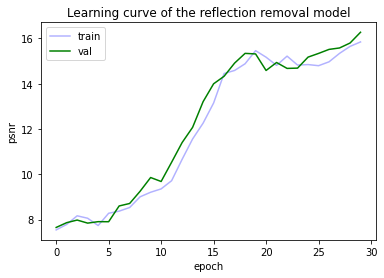

In [22]:
#!L
plot_psnr(training_result_path)

### 4.3 Вывод примеров работы модели на синтетике

In [23]:
#!L
def imshow_samples(model, dataloader, result_path, n_samples=2, figsize=(16, 8)):
    parts = ['reflection', 'image', 'pred', 'transmission']
    part_titles = ['reflection R', 'image I', 'prediction M(I)', 'transmission T']
    
    samples = []
    with torch.no_grad():
        model.eval()
        for i, batch in zip(tqdm(range(n_samples)), dataloader):
            batch = {name:model.preprocess(image) for name, image in batch.items()}
            batch_l = list(batch.values())
            transmission, reflection = batch_l[0], batch_l[1]
            batch = model.get_batch(transmission, reflection)
            batch['pred'] = model.forward(batch['image'])
            j = np.random.randint(BATCH_SIZE)
            samples.append({part: batch[part][j].detach() for part in parts})
    
    _, axes = plt.subplots(n_samples, len(parts), figsize=figsize, squeeze=False)
    for part, ax in zip(part_titles, axes[0]):
        ax.set_title(part)
    for sample, axes_row in zip(samples, axes):
        for part, ax in zip(parts, axes_row):
            ax.set_axis_off()
            t = sample[part]
            img_chw = (torch.clamp(t, 0, 1) * 255).byte().cpu().numpy()
            img = np.transpose(img_chw, axes=(1, 2, 0))
            ax.imshow(img)
    plt.savefig(str(result_path / 'example_synthethic.png'))
    plt.show()

100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


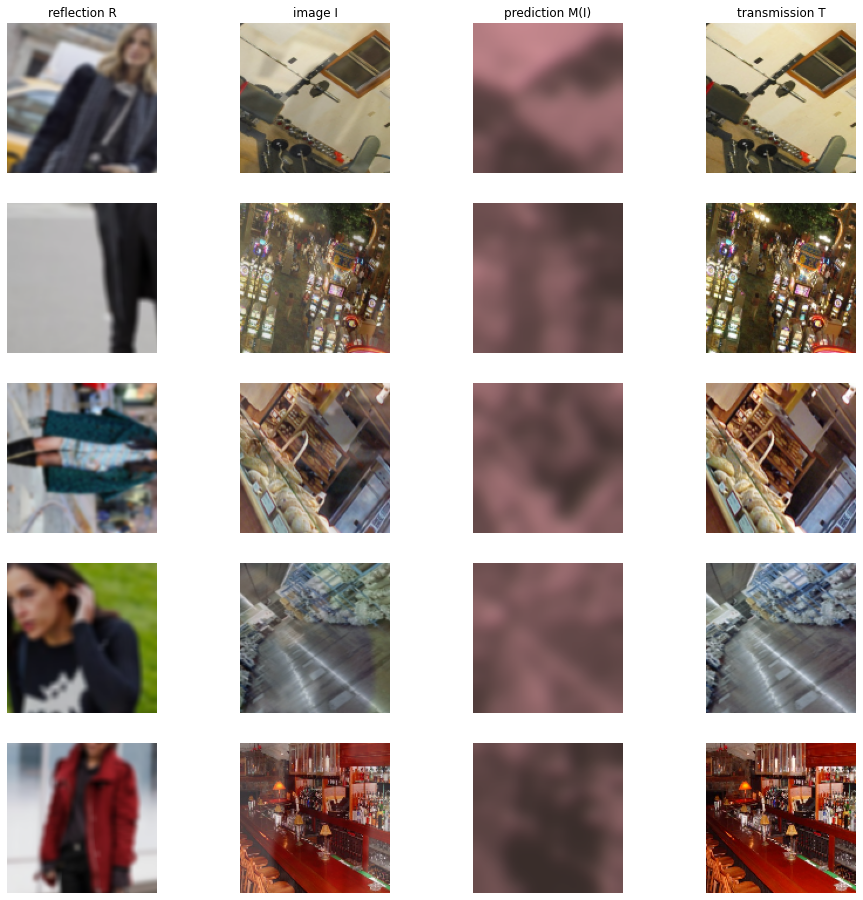

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:809: UserWarning: The following variables cannot be serialized: fused_dataloaders
  warnings.warn(message)


In [24]:
#!L
fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)
imshow_samples(model, fused_dataloaders['val'], training_result_path, n_samples=5, figsize=(16, 16))

### 4.4 Вывод примера работы модели на реальном изображении

In [25]:
#!L
def imshow_samples_real(model, result_path, figsize=(20, 6)):
    k = str(110)
    image_path = f'./data_real/{k}.jpg'
    clean_path = f'./data_real/{k}_clean.jpg'
    
    image = transformloader(image_path, transform=None)
    image = torch.from_numpy(image)

    with torch.no_grad():
        model.eval()
        image_input = model.preprocess(image)
        image_input = torch.unsqueeze(image_input, 0)
        t = model.forward(image_input)
        t = t.detach()[0]

    sample_chw = (torch.clamp(t, 0, 1) * 255).byte().cpu().numpy()
    sample = np.transpose(sample_chw, axes=(1, 2, 0))
        
    image = cv2loader(image_path)
    transmission = cv2loader(clean_path)
    
    samples = [image, sample, transmission]
    parts = ['image', 'model', 'transmission']
    
    _, axes = plt.subplots(1, len(parts), figsize=figsize, squeeze=False)
    for part, ax in zip(parts, axes[0]):
        ax.set_title(part)
    for sample, ax in zip(samples, axes[0]):
        ax.set_axis_off()
        t = sample
        
        if type(t) is np.ndarray:
            img = t
        else:
            img_chw = (torch.clamp(t, 0, 1) * 255).byte().cpu().numpy()
            img = np.transpose(img_chw, axes=(1, 2, 0))
        ax.imshow(sample)

    plt.savefig(str(result_path / 'example_real.png'))
    plt.show()

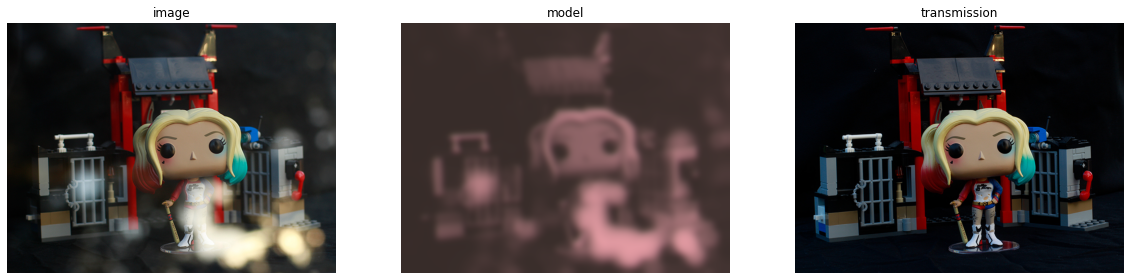

In [26]:
#!L
imshow_samples_real(model, training_result_path)

## PS: советы, наблюдения, эксперименты

PS1 Совет: как выбирать learning rate?  
PS2 Эксперимент: нулевой паддинг лучше зеркального?  
PS3 Эксперимент: простая ResNet-like архитектура тоже работает?  

### PS1 Совет: как выбирать learning rate?
Проходимся по логарифмической шкале learning rate'ов и выбираем тот, на котором максимально падает loss: 
(производная функции потерь имеет отрицательный знак и максимальна по модулю)

In [27]:
#!L
def find_lr(model, dataloader, optimizer, lr_logmin=-7, lr_logmax=1):
    lr = np.logspace(lr_logmin, lr_logmax, len(dataloader))
    losses = []
    for lr_, batch in zip(lr, tqdm(dataloader)):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_
        details = model.compute_all(batch)
        optimizer.zero_grad()
        loss = details['loss']
        loss.backward()
        optimizer.step()
        losses.append(details['loss'].item())
    return lr, losses

def plot_lr(lr, losses, result_path):
    losses = np.array(losses)
    mask = ~np.isnan(losses)

    ylim_min = min(losses) * 0.5
    ylim_max = np.quantile(losses[mask], q=0.8) * 1.5

    plt.plot(lr[mask], losses[mask])
    plt.xscale('log')
    plt.ylim([ylim_min, ylim_max])
    plt.ylabel('loss')
    plt.xlabel('lr')
    
    plt.savefig(str(result_path / 'find_lr.png'))
    plt.show()

In [28]:
#!L
findlr_result_path = generate_result_path()

fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)

findlr_model = get_model()
setup_model_default(findlr_model)
findlr_optimizer = torch.optim.Adam(findlr_model.parameters(), lr=LEARNING_RATE)

result/1618185463


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:809: UserWarning: The following variables cannot be serialized: fused_dataloaders
  warnings.warn(message)


In [29]:
#!L
lr, losses = find_lr(
    findlr_model, fused_dataloaders['train'], findlr_optimizer,
    lr_logmin=-6, lr_logmax=-1)

100%|█████████▉| 518/519 [09:45<00:01,  1.13s/it]
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:809: UserWarning: The following variables cannot be serialized: fused_dataloaders
  warnings.warn(message)


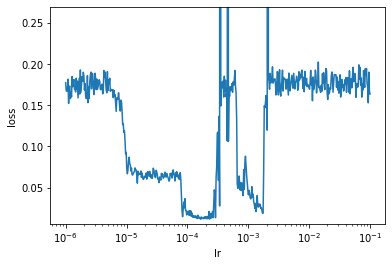

In [30]:
#!L
plot_lr(lr, losses, findlr_result_path)

### PS2 Эксперимент: нулевой паддинг лучше зеркального?  
Spoiler: Нет! Он приводит к блюру на краях!

In [31]:
#!L
def wrap_zeropad(layer, in_, out, kernel_size, normalization=None, activation=None):
    return wrap_(layer, in_, out, kernel_size,
                 normalization, activation,
                 padding = kernel_size // 2, padding_mode='zeros')

def get_zeropad_model():
    return SIRRUNet(in_=3, filters=64, depth=3, wrap=wrap_zeropad).to(DEVICE)

In [32]:
#!L
zeropad_model = get_zeropad_model()
setup_model_default(zeropad_model)
zeropad_optimizer = torch.optim.Adam(zeropad_model.parameters(), lr=LEARNING_RATE)

In [33]:
#!L
zeropad_training_result_path = generate_result_path()

fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)
_ = train(zeropad_model, fused_dataloaders, zeropad_optimizer, MAX_EPOCHS, zeropad_training_result_path)

  0%|          | 0/519 [00:00<?, ?it/s]

result/1618186107
epoch=000


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=001


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=002


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=003


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=004


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=005


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=006


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=007


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=008


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=009


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=010


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=011


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=012


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=013


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=014


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=015


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=016


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=017


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=018


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=019


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=020


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=021


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=022


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=023


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=024


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=025


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=026


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=027


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=028


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=029


TV: loss=0.03148, psnr=15.0:   0%|          | 0/129 [00:00<?, ?it/s]


Finished training.


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:809: UserWarning: The following variables cannot be serialized: fused_dataloaders
  warnings.warn(message)


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


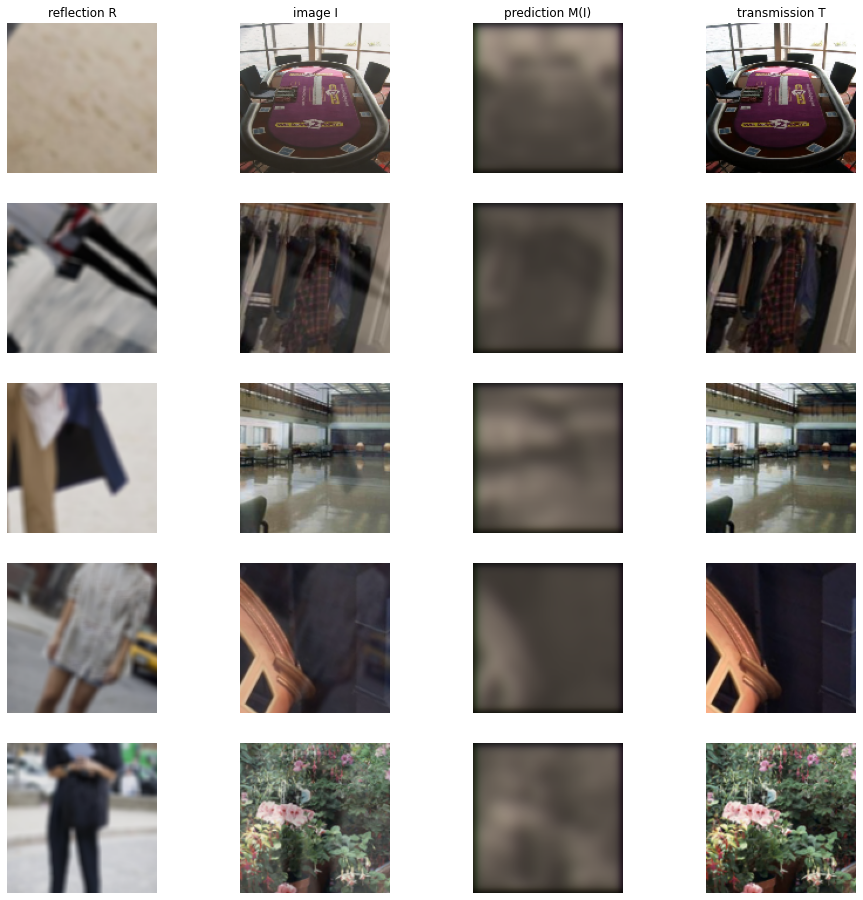

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:809: UserWarning: The following variables cannot be serialized: fused_dataloaders
  warnings.warn(message)


In [34]:
#!L
fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)
imshow_samples(zeropad_model, fused_dataloaders['val'], zeropad_training_result_path, n_samples=5, figsize=(16, 16))

### PS3 Эксперимент: простая ResNet-like архитектура тоже работает?  
Spoiler: Да! И по качеству даже оказывается близка к изначальной модели!

In [35]:
#!L
class ResNetFeatureExtractionCNN(nn.Module):
    def __init__(self, in_, filters, wrap):
        super(ResNetFeatureExtractionCNN, self).__init__()
        self.cnn = nn.Sequential(
            wrap(nn.Conv2d, in_, filters, kernel_size=1, normalization=nn.BatchNorm2d, activation=nn.ReLU),
        )
    
    def forward(self, x):
        return self.cnn(x)


class ResBlock(nn.Module):
    def __init__(self, filters, wrap):
        super(ResBlock, self).__init__()
        self.cnn = nn.Sequential(
            wrap(nn.Conv2d, filters, filters, kernel_size=3, normalization=nn.BatchNorm2d, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=3, normalization=nn.BatchNorm2d, activation=None),
        )
    def forward(self, x):
        return self.cnn(x)

class ReflectionRemovalResNet(nn.Module):
    def __init__(self, filters, length, wrap):
        super(ReflectionRemovalResNet, self).__init__()
        self.blocks = nn.ModuleList([ResBlock(filters, wrap) for _ in range(length)])
    
    def forward(self, x):
        for block in self.blocks:
            skip = x
            residual = block(x)
            x = F.relu(skip + residual)
        return x


class ResNetTransmissionRestorationCNN(nn.Module):
    def __init__(self, filters, out, wrap):
        super(ResNetTransmissionRestorationCNN, self).__init__()
        self.cnn = nn.Sequential(
            wrap(nn.Conv2d, filters, out, kernel_size=1, normalization=nn.BatchNorm2d, activation=nn.ReLU),
        )
    
    def forward(self, x):
        return self.cnn(x)

class SIRRResNet(ModuleWithSIRRComputeAll):
    def __init__(self, in_, filters, length, wrap):
        super(SIRRResNet, self).__init__()
        self.feature_extraction = ResNetFeatureExtractionCNN(in_, filters, wrap)
        self.reflection_removal = ReflectionRemovalResNet(filters, length, wrap)
        self.transmission_restoration = ResNetTransmissionRestorationCNN(filters, in_, wrap)
    
    def forward(self, x):
        features = self.feature_extraction(x)
        features_reflection_removed = self.reflection_removal(features)
        restored = self.transmission_restoration(features_reflection_removed)
        return restored


def get_resnet_model():
    return SIRRResNet(in_=3, filters=64, length=10, wrap=wrap_reflectpad).to(DEVICE)
    

if DEBUG:
    model_ = get_resnet_model()
    summary(model_, (3, *IMG_SHAPE))

In [36]:
#!L
resnet_model = get_resnet_model()
setup_model_default(resnet_model)
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=LEARNING_RATE)

In [37]:
#!L
resnet_training_result_path = generate_result_path()

fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)
_ = train(resnet_model, fused_dataloaders, optimizer, MAX_EPOCHS, resnet_training_result_path)

  0%|          | 0/519 [00:00<?, ?it/s]

result/1618186259
epoch=000


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=001


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=002


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=003


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=004


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=005


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=006


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=007


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=008


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=009


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=010


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=011


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=012


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=013


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=014


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=015


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=016


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=017


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=018


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=019


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=020


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=021


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=022


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=023


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=024


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=025


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=026


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=027


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=028


  0%|          | 0/519 [00:00<?, ?it/s]

epoch=029


TV: loss=0.02521, psnr=16.0:   0%|          | 0/129 [00:00<?, ?it/s]


Finished training.


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:809: UserWarning: The following variables cannot be serialized: fused_dataloaders
  warnings.warn(message)


In [38]:
#!L
fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)
_ = evaluate(resnet_model, fused_dataloaders['val'])

TV: loss=0.02575, psnr=15.9:   0%|          | 0/129 [00:01<?, ?it/s]
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:809: UserWarning: The following variables cannot be serialized: fused_dataloaders
  warnings.warn(message)


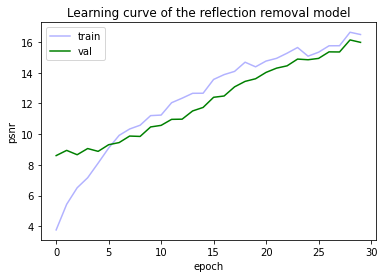

In [39]:
#!L
plot_psnr(resnet_training_result_path)

In [ ]:
#!L
fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)
imshow_samples(resnet_model, fused_dataloaders['val'], resnet_training_result_path, n_samples=5, figsize=(16, 16))

100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


In [ ]:
#!L
imshow_samples_real(resnet_model, resnet_training_result_path)